In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from typing import Literal

from langchain_anthropic import ChatAnthropic 
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt, Command

from src.open_deep_research.state import ReportStateInput, ReportStateOutput, Sections, ReportState, SectionState, SectionOutputState, Queries, Feedback
from src.open_deep_research.prompts import report_planner_query_writer_instructions, report_planner_instructions, query_writer_instructions, section_writer_instructions, final_section_writer_instructions, section_grader_instructions
from src.open_deep_research.configuration import Configuration
from src.open_deep_research.utils import tavily_search_async, deduplicate_and_format_sources, format_sections, perplexity_search

# Set writer model
writer_model = ChatAnthropic(model=Configuration.writer_model, temperature=0) 

# Nodes
async def generate_report_plan(state: ReportState, config: RunnableConfig) -> Command[Literal["generate_report_plan","build_section_with_web_research"]]:
    """ Generate the report plan """

    # Inputs
    topic = state["topic"]
    feedback = state.get("feedback_on_report_plan", None)

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]

    # Handle both cases for search_api:
    # 1. When selected in Studio UI -> returns a string (e.g. "tavily")
    # 2. When using default -> returns an Enum (e.g. SearchAPI.TAVILY)
    if isinstance(configurable.search_api, str):
        search_api = configurable.search_api
    else:
        search_api = configurable.search_api.value

    # Search the web
    if search_api == "tavily":
        search_results = await tavily_search_async(query_list)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "perplexity":
        search_results = perplexity_search(query_list)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Set the planner provider
    if isinstance(configurable.planner_provider, str):
        planner_provider = configurable.planner_provider
    else:
        planner_provider = configurable.planner_provider.value

    # Set the planner model
    if  planner_provider == "openai":
        planner_llm = ChatOpenAI(model=configurable.planner_model) 
    elif planner_provider == "groq":
        planner_llm = ChatGroq(model=configurable.planner_model)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")

    # Generate sections 
    structured_llm = planner_llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    # Get sections
    sections = report_sections.sections

    """ Get feedback on the report plan """
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    feedback = interrupt(f"Please provide feedback on the following report plan. \n\n{sections_str}\n\n Pass 'True' to approve the report plan or provide feedback to regenerate the report plan:")

    print(f"Feedback: {feedback}")
    print(f"Feedback type: {type(feedback)}")

    # If the user approves the report plan, kick off section writing
    # if isinstance(feedback, bool) and feedback is True:
    if isinstance(feedback, bool):
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_with_web_research", {"section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ],
        update={"sections": sections})
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # treat this as feedback
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")
    
def generate_queries(state: SectionState, config: RunnableConfig):
    """ Generate search queries for a report section """

    # Get state 
    section = state["section"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState, config: RunnableConfig):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Web search
    query_list = [query.search_query for query in search_queries]
    
    # Handle both cases for search_api:
    # 1. When selected in Studio UI -> returns a string (e.g. "tavily")
    # 2. When using default -> returns an Enum (e.g. SearchAPI.TAVILY)
    if isinstance(configurable.search_api, str):
        search_api = configurable.search_api
    else:
        search_api = configurable.search_api.value

    # Search the web
    if search_api == "tavily":
        search_results = await tavily_search_async(query_list)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=5000, include_raw_content=True)
    elif search_api == "perplexity":
        search_results = perplexity_search(query_list)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=5000, include_raw_content=False)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")

    return {"source_str": source_str, "search_iterations": state["search_iterations"] + 1}

def write_section(state: SectionState, config: RunnableConfig) -> Command[Literal[END,"search_web"]]:
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str, section_content=section.content)

    # Generate section  
    section_content = writer_model.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Grade prompt 
    section_grader_instructions_formatted = section_grader_instructions.format(section_topic=section.description,section=section.content)

    # Feedback 
    structured_llm = writer_model.with_structured_output(Feedback)
    feedback = structured_llm.invoke([SystemMessage(content=section_grader_instructions_formatted)]+[HumanMessage(content="Grade the report and consider follow-up questions for missing information:")])

    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        # Publish the section to completed sections 
        return  Command(
        update={"completed_sections": [section]},
        goto=END
    )
    else:
        # Update the existing section with new content and update search queries
        return  Command(
        update={"search_queries": feedback.follow_up_queries, "section": section},
        goto="search_web"
        )
    
def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    section_content = writer_model.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Report section sub-graph -- 

# Add nodes 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")

# Outer graph -- 

# Add nodes
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


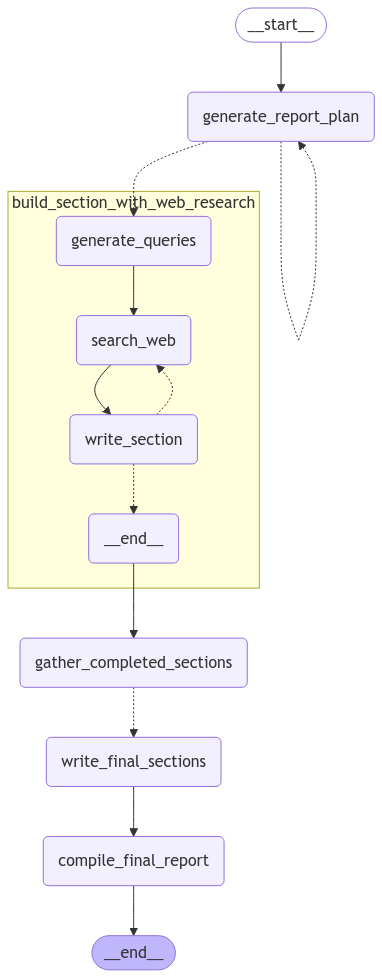

In [67]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [68]:
import uuid 

# Fast config with DeepSeek-R1-Distill-Llama-70B
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "max_search_depth": 1,
                           "planner_model": "deepseek-r1-distill-llama-70b"}}

# Fast config with o3-mini
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "max_search_depth": 1,
                           "planner_model": "o3-mini"}}

# Slow config, more in depth
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "openai",
                           "max_search_depth": 2,
                           "planner_model": "o3-mini"}}

# Create a topic
topic = "Overview of the AI inference market with focus on Fireworks, Together.ai, Groq"

# Run the graph until the interruption
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    print(event)
    print("\n")


{'__interrupt__': (Interrupt(value="Please provide feedback on the following report plan. \n\nSection: Introduction\nDescription: Provides a brief overview of the AI inference market and outlines the report's focus on Fireworks AI, Together.ai, and Groq.\nResearch needed: No\n\n\nSection: AI Inference Market Overview\nDescription: Discusses the current state of the AI inference market, including key trends, definitions, and fundamental concepts. Sets the stage for understanding where the three platforms fit within the broader market.\nResearch needed: Yes\n\n\nSection: Fireworks AI Analysis\nDescription: Examines Fireworks AI in detail, covering its unique capabilities, performance metrics, API speed, real-world usage, and positioning in internal and external benchmarks.\nResearch needed: Yes\n\n\nSection: Together.ai Analysis\nDescription: Analyzes Together.ai, focusing on its unique features, comparative advantages, pricing models, and the insights derived from real user reviews and 

In [ ]:
# Pass feedback to update the report plan  
async for event in graph.astream(Command(resume="Include a revenue estimate (ARR) in the sections focused on Groq, Together.ai, and Fireworks"), thread, stream_mode="updates"):
    print(event)
    print("\n")

In [ ]:
# Pass True to approve the report plan 
async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

In [21]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# AI Inference Market and Key Players Overview

The AI inference market is experiencing explosive growth, projected to expand from $24.6 billion in 2024 to $133.2 billion by 2034. This transformation is being driven by innovative companies developing breakthrough optimization technologies that dramatically improve performance while reducing costs. Among these pioneers, Fireworks AI has demonstrated enterprise-grade reliability by processing 140 billion tokens daily, while Together.ai has achieved 4x faster decoding throughput than traditional solutions. Groq's Language Processing Unit (LPU) has emerged as a particularly disruptive force, offering competitive pricing from $0.05 to $0.99 per million tokens while securing a $2.8 billion valuation.

## Key Players Comparison

| Feature | Fireworks AI | Together.ai | Groq |
|---------|-------------|-------------|------|
| Daily Processing | 140B tokens | 400 tokens/sec | Not disclosed |
| Pricing Range | $0.10-$1.20/M tokens | Custom pricing | $0.05-$0.99/M tokens |
| Key Innovation | Parameter-based pricing | FlashAttention-3 | Language Processing Unit |
| Enterprise Users | Uber, DoorDash | Salesforce, Washington Post | Hunch AI, aiXplain |
| Valuation | $552M | $100M ARR | $2.8B |

These players are reshaping the inference landscape through distinct approaches to optimization and pricing, with each targeting different segments of the rapidly expanding market. Their continued innovation suggests further disruption in the AI infrastructure space.

## Global AI Inference Market Analysis

**The AI inference market is projected to grow from $24.6 billion in 2024 to $133.2 billion by 2034, driven by breakthrough optimization technologies that are dramatically improving performance while reducing costs.** Cloud deployment currently dominates with 55% market share, though on-premises solutions are gaining traction for latency-sensitive and security-focused applications.

NVIDIA maintains market leadership with approximately 80% share of AI chips, while competitors like AMD, Intel, and cloud providers are investing heavily in specialized inference solutions. Recent advances in speculative decoding and compilation techniques have enabled up to 2x higher throughput at 50% lower costs for popular models like Llama and Mixtral.

Key barriers to adoption include:
- High infrastructure costs and unclear ROI
- Data quality and quantity challenges
- Integration complexity with existing systems
- Skills gaps in AI/ML expertise
- Privacy and regulatory concerns

North America leads regional adoption with 38% market share, particularly in financial services and healthcare verticals. Microsoft's implementation of NVIDIA inference solutions for Copilot demonstrates the technology's enterprise readiness.

### Sources
- Restack AI Hardware Analysis 2024: https://www.restack.io/p/hardware-innovations-for-ai-technologies-answer-leading-ai-hardware-companies-2024
- NVIDIA Developer Blog: https://developer.nvidia.com/blog/optimize-ai-inference-performance-with-nvidia-full-stack-solutions/
- Market.us AI Inference Report: https://scoop.market.us/ai-inference-server-market-news/

## Fireworks AI Technical Analysis

**Fireworks AI combines an innovative pricing model with proven enterprise performance, demonstrated by processing 140 billion tokens daily with 99.99% API uptime across 12,000 users.** Their tiered pricing structure scales with usage, starting at $0.10 per million tokens for small models and reaching $1.20 per million tokens for large MoE architectures.

The platform offers specialized pricing for different modalities:
- Text generation with parameter-based pricing ($0.10-$1.20/M tokens)
- Image generation at $0.00013 per step
- Speech-to-text processing from $0.0009 per audio minute
- On-demand GPU deployments ranging from $2.90 to $9.99 per hour

A notable implementation at Sourcegraph showcases the platform's capabilities, where StarCoder deployment doubled code completion acceptance rates while cutting backend latency by 50%. The company's recent $52M Series B funding values it at $552M, with Forbes estimating 2023 revenue at $3M.

Enterprise customers including Uber, DoorDash, and Upwork have adopted Fireworks AI's infrastructure, citing lower costs and reduced latency compared to alternatives. The platform's spending limits increase with usage history, from $50/month to custom enterprise tiers exceeding $50,000/month.

### Sources
- Fireworks AI Blog Spring Update: https://fireworks.ai/blog/spring-update-faster-models-dedicated-deployments-postpaid-pricing
- AWS Case Study: https://aws.amazon.com/solutions/case-studies/fireworks-ai-case-study/
- Funding News: https://www.pymnts.com/news/investment-tracker/2024/fireworks-ai-valued-552-million-dollars-after-new-funding-round/

## Together.ai's Inference Stack Analysis

**Together.ai has revolutionized LLM inference by achieving 4x faster decoding throughput than open-source vLLM through an integrated approach combining hardware optimization and algorithmic innovations.** Their Inference Engine 2.0 demonstrates superior performance by processing over 400 tokens per second on Meta's Llama 3 8B model.

The technical foundation relies on four key innovations:
- FlashAttention-3 optimization achieving 75% GPU utilization
- Custom-built draft models trained beyond 10x Chinchilla optimal
- Advanced speculative decoding combining Medusa and Sequoia techniques
- Quality-preserving quantization matching FP16 precision

A notable case study demonstrates their efficiency at scale: using just two A100 GPUs, Together Lite outperforms vLLM running on eight H100 GPUs by 30% in common inference scenarios. This translates to a 12x cost reduction compared to standard deployments.

The Enterprise Platform builds on these innovations while maintaining SOC 2, GDPR, and HIPAA compliance. Major enterprises including Salesforce and The Washington Post have validated its performance in production environments, contributing to Together.ai reaching $100M ARR within 10 months of launch.

### Sources
- Together Inference Engine 2.0 Announcement: https://www.together.ai/blog/together-inference-engine-2
- Enterprise Platform Security: https://www.togetherplatform.com/security-compliance
- Speculative Decoding Implementation: https://www.together.ai/blog/speculative-decoding-for-high-throughput-long-context-inference

## Groq's Inference Engine Performance and Market Traction

**Groq's Language Processing Unit (LPU) has demonstrated unprecedented inference speeds while achieving significant market validation, with an estimated $3.4 million revenue in 2023 and a $2.8 billion valuation following their August 2024 Series D round.**

The LPU's competitive pricing structure ranges from $0.05 to $0.99 per million tokens, depending on model size and input/output requirements. For example, their Llama 3.3 70B implementation charges $0.59 per million input tokens and $0.79 per million output tokens, positioning them favorably against cloud competitors.

Developer adoption has been robust, with notable implementations including:
- Hunch AI Workspace for rapid prototyping
- aiXplain's real-time inference solutions
- Argonne National Laboratory's research applications
- Embodied's Moxie education robot

The platform offers an OpenAI-compatible API supporting multiple models including Llama 3.3, Mixtral 8x7b, and Gemma 2. Integration options include LangChain compatibility and Retrieval Augmented Generation capabilities, enabling developers to incorporate proprietary data into their applications.

### Sources
- Sacra Company Analysis: https://sacra.com/c/groq/
- Groq Pricing Documentation: https://groq.com/pricing/
- ChipStrat Analysis: https://www.chipstrat.com/p/the-rise-of-groq-slow-then-fast
- Groq API Documentation: https://distilabel.argilla.io/1.2.1/api/llm/groq/

## Market and Provider Analysis Summary

The AI inference market is experiencing rapid growth, projected to reach $133.2 billion by 2034, with cloud deployment currently dominating at 55% market share. Among emerging providers, Fireworks AI, Together.ai, and Groq demonstrate distinct competitive advantages in performance and pricing strategies.

| Provider | Key Differentiator | Performance Metric | Revenue/Valuation |
|----------|-------------------|-------------------|-------------------|
| Fireworks AI | Enterprise-grade reliability | 140B tokens/day, 99.99% uptime | $3M (2023), $552M valuation |
| Together.ai | Advanced optimization stack | 4x faster than vLLM, 400 tokens/sec | $100M ARR |
| Groq | Custom LPU architecture | Industry-leading latency | $3.4M (2023), $2.8B valuation |

These providers are addressing key market barriers through innovative pricing models, ranging from $0.05 to $1.20 per million tokens, while delivering specialized solutions for different modalities and use cases. Their success in attracting major enterprise customers suggests growing market maturity, though NVIDIA's 80% chip market share indicates continued infrastructure dependencies.